In [2]:
from load_sim_data import *
from load_shp import *
from sim_eval_pkg import *

Updated on 2025-07-23


In [3]:
def calculate_spatial_variability_and_info_loss(var_1deg, var_025deg, var_14km, var_1d32deg):
    window_sizes = {
        '1deg': 3,      # ~100km
        '0.25deg': 12,  # ~25km  
        '14km': 24,     # ~14km
        '1/32deg': 96   # ~3.5km
    }
    
    var_data = {
        '1deg': var_1deg,
        '0.25deg': var_025deg, 
        '14km': var_14km,
        '1/32deg': var_1d32deg
    }
    
    resolutions = ['1/32deg', '14km', '0.25deg', '1deg']
    scale_ratios = [1, 4, 8, 32] 
    
    def compute_local_stats(da, window, region_bounds):
        try:
            da_region = da.sel(lat=region_bounds['lat'], lon=region_bounds['lon'])
            da_region = da_region.where((da_region > 0) & (da_region < 200)) # remove infinite and unrealistically large values
            
            regional_mean = da_region.mean(skipna=True)
            if regional_mean != 0 and not np.isnan(regional_mean):
                da_norm = da_region / regional_mean
            else:
                da_norm = da_region
            
            rolling = da_norm.rolling(lat=window, lon=window, center=True, min_periods=1)
            local_std = rolling.std()
            rolling_orig = da_region.rolling(lat=window, lon=window, center=True, min_periods=1)
            std = rolling_orig.std().values.flatten()
            std = std[~np.isnan(std)]
            return std
        except Exception as e:
            print(f"Error in compute_local_stats: {e}")
            return np.array([])
    
    results = {}
    
    for region_name, bounds in regions.items():
        print(f"Processing region: {region_name}")
        
        std_values = []
        valid_resolutions = []
        
        for res in resolutions:
            if res in var_data:
                std = compute_local_stats(var_data[res], window_sizes.get(res, 3), bounds)
                if len(std) > 0:
                    std_mean = np.nanmean(std)
                    std_values.append(std_mean)
                    valid_resolutions.append(res)
                    print(f"  {res}: std = {std_mean:.4f}")
                else:
                    print(f"  {res}: No valid data")
        
        if len(std_values) >= 2:
            std_ratios = [std/std_values[0] if std_values[0] > 0 else np.nan for std in std_values]
            info_loss = [(1 - ratio) * 100 if not np.isnan(ratio) else np.nan for ratio in std_ratios]
            if len(std_values) >= 3:
                valid_scale_ratios = scale_ratios[:len(std_values)]
                
                log_scales = np.log(valid_scale_ratios[1:])
                log_ratios = np.log(std_ratios[1:])
                
                valid_idx = ~(np.isnan(log_scales) | np.isnan(log_ratios))
                if np.sum(valid_idx) >= 2:
                    slope, intercept, r_value, p_value, std_err = stats.linregress(
                        log_scales[valid_idx], log_ratios[valid_idx])
                    beta = slope
                    r_squared = r_value**2
                else:
                    beta, r_squared = np.nan, np.nan
            else:
                beta, r_squared = np.nan, np.nan
            
            results[region_name] = {
                'resolutions': valid_resolutions,
                'std_values': std_values,
                'std_ratios': std_ratios,
                'info_loss': info_loss,
                'beta': beta,
                'r_squared': r_squared,
                'scale_ratios': scale_ratios[:len(std_values)]
            }
            
            print(f"  β = {beta:.3f}, R² = {r_squared:.3f}")
            print(f"  Avg info loss = {np.nanmean(info_loss[1:]):.1f}%")
    return results

In [4]:
variability_results=calculate_spatial_variability_and_info_loss(bowen_ratio_1deg, bowen_ratio_025deg, 
                                                                bowen_ratio_14km, bowen_ratio_1d32deg)

Processing region: R1
  1/32deg: std = 0.1083
  14km: std = 0.0915
  0.25deg: std = 0.0711
  1deg: std = 0.0641
  β = -0.158, R² = 0.830
  Avg info loss = 30.2%
Processing region: R2
  1/32deg: std = 0.1946
  14km: std = 0.1526
  0.25deg: std = 0.1055
  1deg: std = 0.0692
  β = -0.370, R² = 0.977
  Avg info loss = 44.0%
Processing region: R3
  1/32deg: std = 0.4774
  14km: std = 0.4571
  0.25deg: std = 0.3912
  1deg: std = 0.3901
  β = -0.066, R² = 0.586
  Avg info loss = 13.5%
Processing region: R4
  1/32deg: std = 1.8469
  14km: std = 1.7892
  0.25deg: std = 1.8159
  1deg: std = 1.6256
  β = -0.051, R² = 0.805
  Avg info loss = 5.6%


In [5]:
variability_results2=calculate_spatial_variability_and_info_loss(net_radiation_1deg, net_radiation_025deg, 
                                                                net_radiation_14km, net_radiation_1d32deg)

Processing region: R1
  1/32deg: std = 3.7981
  14km: std = 3.3422
  0.25deg: std = 3.1178
  1deg: std = 2.7538
  β = -0.093, R² = 0.999
  Avg info loss = 19.1%
Processing region: R2
  1/32deg: std = 4.4989
  14km: std = 3.8021
  0.25deg: std = 3.7194
  1deg: std = 3.1352
  β = -0.097, R² = 0.948
  Avg info loss = 21.0%
Processing region: R3
  1/32deg: std = 6.2912
  14km: std = 4.6477
  0.25deg: std = 4.3108
  1deg: std = 2.4880
  β = -0.314, R² = 0.951
  Avg info loss = 39.4%
Processing region: R4
  1/32deg: std = 8.6669
  14km: std = 7.0801
  0.25deg: std = 6.8047
  1deg: std = 4.8509
  β = -0.191, R² = 0.944
  Avg info loss = 27.9%


In [6]:
def extract_driver_statistics(surfdata_file):
    ds = xr.open_dataset(surfdata_file)
    
    driver_vars = [
        'EM_ROOF', 'EM_IMPROAD', 'EM_PERROAD', 'EM_WALL',
        'ALB_ROOF_DIR', 'ALB_IMPROAD_DIR', 'ALB_PERROAD_DIR', 'ALB_WALL_DIR',
        'CANYON_HWR', 'HT_ROOF', 'WTLUNIT_ROOF', 'WTROAD_PERV'
    ]

    available_vars = [var for var in driver_vars if var in ds.variables]
    missing_vars = [var for var in driver_vars if var not in ds.variables]
    
    print(f"Found variables: {available_vars}")
    if missing_vars:
        print(f"Missing variables: {missing_vars}")
    
    driver_stats = {}
    
    for region_name, bounds in regions.items():
        print(f"Processing region: {region_name}")
        region_stats = {}
        
        for var_name in available_vars:
            try:
                if 'ALB' in var_name:
                    var_data = ds[var_name].sel(numrad=0,numurbl=2)
                else:
                    var_data = ds[var_name].sel(numurbl=2)

                print('selecting lat lon')
                var_region = var_data.sel(lat=bounds['lat'],lon=bounds['lon'])
                mean_val = float(var_region.mean(skipna=True))
                std_val = float(var_region.std(skipna=True))
                region_stats[f'μ_{var_name}'] = mean_val
                region_stats[f'σ_{var_name}'] = std_val
                
                print(f"  {var_name}: μ={mean_val:.4f}, σ={std_val:.4f}")
                
            except Exception as e:
                print(f"  Error processing {var_name}: {e}")
                continue
        
        driver_stats[region_name] = region_stats
    return driver_stats

In [7]:
surfdata_file='/glade/work/yifanc17/02_data/cesmdata/surfdata/CONUS_3p75/surfdata_CONUS_1d32deg_hist_usurf_adjusted_pct_2015_16pfts_TEST_THR_latlon_c25521.nc'
driver_stats=extract_driver_statistics(surfdata_file)

Found variables: ['EM_ROOF', 'EM_IMPROAD', 'EM_PERROAD', 'EM_WALL', 'ALB_ROOF_DIR', 'ALB_IMPROAD_DIR', 'ALB_PERROAD_DIR', 'ALB_WALL_DIR', 'CANYON_HWR', 'HT_ROOF', 'WTLUNIT_ROOF', 'WTROAD_PERV']
Processing region: R1
selecting lat lon
  EM_ROOF: μ=0.9623, σ=0.0573
selecting lat lon
  EM_IMPROAD: μ=0.9619, σ=0.0573
selecting lat lon
  EM_PERROAD: μ=0.9672, σ=0.0551
selecting lat lon
  EM_WALL: μ=0.9593, σ=0.0577
selecting lat lon
  ALB_ROOF_DIR: μ=0.1553, σ=0.0291
selecting lat lon
  ALB_IMPROAD_DIR: μ=0.1565, σ=0.0255
selecting lat lon
  ALB_PERROAD_DIR: μ=0.1222, σ=0.0201
selecting lat lon
  ALB_WALL_DIR: μ=0.2357, σ=0.0364
selecting lat lon
  CANYON_HWR: μ=0.1327, σ=0.1232
selecting lat lon
  HT_ROOF: μ=8.7949, σ=2.8423
selecting lat lon
  WTLUNIT_ROOF: μ=0.0991, σ=0.1465
selecting lat lon
  WTROAD_PERV: μ=0.8770, σ=0.1103
Processing region: R2
selecting lat lon
  EM_ROOF: μ=0.8133, σ=0.3560
selecting lat lon
  EM_IMPROAD: μ=0.8129, σ=0.3559
selecting lat lon
  EM_PERROAD: μ=0.8150, σ

In [8]:
def prepare_pca_data(variability_results, driver_stats, target_metric='info_loss'):
    print(f"Preparing PCA data with target metric: {target_metric}")
    
    pca_data = []
    target_values = []
    region_names = []
    
    for region_name in variability_results.keys():
        if region_name in driver_stats:
            
            if target_metric == 'info_loss':
                info_loss_values = variability_results[region_name]['info_loss'][1:]
                target_val = np.nanmean(info_loss_values)
            elif target_metric == 'beta':
                target_val = variability_results[region_name]['beta']
            elif target_metric == 'std_ratio':
                std_ratios = variability_results[region_name]['std_ratios']
                target_val = std_ratios[-1] if len(std_ratios) > 0 else np.nan
            else:
                print(f"Unknown target metric: {target_metric}")
                continue
            
            if not np.isnan(target_val):
                target_values.append(target_val)
                region_names.append(region_name)
                driver_row = []
                driver_names = []
                for stat_name, stat_value in driver_stats[region_name].items():
                    driver_row.append(stat_value)
                    driver_names.append(stat_name)
                
                pca_data.append(driver_row)
    
    if len(pca_data) == 0:
        print("No valid data for PCA analysis")
        return None

    pca_df = pd.DataFrame(pca_data, columns=driver_names)
    pca_df['target'] = target_values
    pca_df['region'] = region_names
    
    print(f"PCA dataset shape: {pca_df.shape}")
    print(f"Target variable statistics:")
    print(f"  Mean: {np.mean(target_values):.3f}")
    print(f"  Std: {np.std(target_values):.3f}")
    print(f"  Range: {np.min(target_values):.3f} to {np.max(target_values):.3f}")
    
    return pca_df

In [9]:
pca_df=prepare_pca_data(variability_results, driver_stats, target_metric='info_loss')

Preparing PCA data with target metric: info_loss
PCA dataset shape: (4, 26)
Target variable statistics:
  Mean: 23.323
  Std: 14.864
  Range: 5.592 to 43.955


In [10]:
pca_df2=prepare_pca_data(variability_results2, driver_stats, target_metric='info_loss')

Preparing PCA data with target metric: info_loss
PCA dataset shape: (4, 26)
Target variable statistics:
  Mean: 26.868
  Std: 7.916
  Range: 19.138 to 39.352


In [11]:
def perform_pca_analysis(pca_df, n_components=2):
    print(f"Performing PCA with {n_components} components...")
    
    feature_cols = [col for col in pca_df.columns if col not in ['target', 'region']]
    X = pca_df[feature_cols].copy()
    
    print(f"Features: {feature_cols}")

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    pca_results = {
        'pca': pca,
        'scaler': scaler,
        'imputer': imputer,
        'X_pca': X_pca,
        'feature_names': feature_cols,
        'loadings': pca.components_,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'explained_variance': pca.explained_variance_,
        'pca_df': pca_df
    }
    
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.3f}")
    
    for i in range(min(2, n_components)): # top loadings
        print(f"\nTop drivers for PC{i+1}:")
        loadings_pc = pca.components_[i]
        top_drivers = sorted(zip(feature_cols, np.abs(loadings_pc)), 
                           key=lambda x: x[1], reverse=True)[:5]
        for driver, loading in top_drivers:
            direction = "+" if loadings_pc[feature_cols.index(driver)] > 0 else "-"
            print(f"  {direction}{driver}: {loading:.3f}")
    
    return pca_results

In [12]:
pca_results=perform_pca_analysis(pca_df, n_components=2)

Performing PCA with 2 components...
Features: ['μ_EM_ROOF', 'σ_EM_ROOF', 'μ_EM_IMPROAD', 'σ_EM_IMPROAD', 'μ_EM_PERROAD', 'σ_EM_PERROAD', 'μ_EM_WALL', 'σ_EM_WALL', 'μ_ALB_ROOF_DIR', 'σ_ALB_ROOF_DIR', 'μ_ALB_IMPROAD_DIR', 'σ_ALB_IMPROAD_DIR', 'μ_ALB_PERROAD_DIR', 'σ_ALB_PERROAD_DIR', 'μ_ALB_WALL_DIR', 'σ_ALB_WALL_DIR', 'μ_CANYON_HWR', 'σ_CANYON_HWR', 'μ_HT_ROOF', 'σ_HT_ROOF', 'μ_WTLUNIT_ROOF', 'σ_WTLUNIT_ROOF', 'μ_WTROAD_PERV', 'σ_WTROAD_PERV']
Explained variance ratio: [0.65919958 0.30056949]
Total variance explained: 0.960

Top drivers for PC1:
  +σ_EM_PERROAD: 0.251
  +σ_EM_ROOF: 0.251
  +σ_EM_WALL: 0.251
  +σ_EM_IMPROAD: 0.248
  -μ_EM_PERROAD: 0.247

Top drivers for PC2:
  +μ_ALB_ROOF_DIR: 0.359
  -μ_WTROAD_PERV: 0.343
  +σ_ALB_PERROAD_DIR: 0.333
  +μ_ALB_WALL_DIR: 0.316
  +σ_ALB_IMPROAD_DIR: 0.295


In [13]:
pca_results2=perform_pca_analysis(pca_df2, n_components=2)

Performing PCA with 2 components...
Features: ['μ_EM_ROOF', 'σ_EM_ROOF', 'μ_EM_IMPROAD', 'σ_EM_IMPROAD', 'μ_EM_PERROAD', 'σ_EM_PERROAD', 'μ_EM_WALL', 'σ_EM_WALL', 'μ_ALB_ROOF_DIR', 'σ_ALB_ROOF_DIR', 'μ_ALB_IMPROAD_DIR', 'σ_ALB_IMPROAD_DIR', 'μ_ALB_PERROAD_DIR', 'σ_ALB_PERROAD_DIR', 'μ_ALB_WALL_DIR', 'σ_ALB_WALL_DIR', 'μ_CANYON_HWR', 'σ_CANYON_HWR', 'μ_HT_ROOF', 'σ_HT_ROOF', 'μ_WTLUNIT_ROOF', 'σ_WTLUNIT_ROOF', 'μ_WTROAD_PERV', 'σ_WTROAD_PERV']
Explained variance ratio: [0.65919958 0.30056949]
Total variance explained: 0.960

Top drivers for PC1:
  +σ_EM_PERROAD: 0.251
  +σ_EM_ROOF: 0.251
  +σ_EM_WALL: 0.251
  +σ_EM_IMPROAD: 0.248
  -μ_EM_PERROAD: 0.247

Top drivers for PC2:
  +μ_ALB_ROOF_DIR: 0.359
  -μ_WTROAD_PERV: 0.343
  +σ_ALB_PERROAD_DIR: 0.333
  +μ_ALB_WALL_DIR: 0.316
  +σ_ALB_IMPROAD_DIR: 0.295


In [14]:
feature_name_dict={'μ_EM_ROOF': r'$μ_{EMr}$',
 'σ_EM_ROOF': r'$σ_{EMr}$',
 'μ_EM_IMPROAD': r'$μ_{EMir}$',
 'σ_EM_IMPROAD': r'$σ_{EMir}$',
 'μ_EM_PERROAD': r'$μ_{EMpr}$',
 'σ_EM_PERROAD': r'$σ_{EMpr}$',
 'μ_EM_WALL': r'$μ_{EMw}$',
 'σ_EM_WALL': r'$σ_{EMw}$',
 'μ_ALB_ROOF_DIR': r'$μ_{ALBr}$',
 'σ_ALB_ROOF_DIR': r'$σ_{ALBr}$',
 'μ_ALB_IMPROAD_DIR': r'$μ_{ALBir}$',
 'σ_ALB_IMPROAD_DIR': r'$σ_{ALBir}$',
 'μ_ALB_PERROAD_DIR': r'$μ_{ALBpr}$',
 'σ_ALB_PERROAD_DIR': r'$σ_{ALBpr}$',
 'μ_ALB_WALL_DIR': r'$μ_{ALBw}$',
 'σ_ALB_WALL_DIR': r'$σ_{ALBw}$',
 'μ_CANYON_HWR': r'$μ_{HWR}$',
 'σ_CANYON_HWR': r'$σ_{HWR}$',
 'μ_HT_ROOF': r'$μ_{HT}$',
 'σ_HT_ROOF': r'$σ_{HT}$',
 'μ_WTLUNIT_ROOF': r'$μ_{WTR}$',
 'σ_WTLUNIT_ROOF': r'$σ_{WTR}$',
 'μ_WTROAD_PERV': r'$μ_{WTP}$',
 'σ_WTROAD_PERV': r'$σ_{WTP}$'
}

In [15]:
X_pca = pca_results['X_pca']
loadings = pca_results['loadings']
feature_names = pca_results['feature_names']
explained_var = pca_results['explained_variance_ratio']
pca_df = pca_results['pca_df']
top_features_by_region = {}

pc_scores = X_pca[:, :2]           
pc_loadings = loadings[:2, :]      

for i, region in enumerate(pca_df['region']):
    region_score = pc_scores[i, :]                      
    importances = region_score @ pc_loadings           

    top5_idx = np.argsort(np.abs(importances))[-5:][::-1]
    top5_features = [feature_names[j] for j in top5_idx]
    top_features_by_region[region] = top5_features

In [16]:
X_pca = pca_results2['X_pca']
loadings = pca_results2['loadings']
feature_names = pca_results2['feature_names']
explained_var = pca_results2['explained_variance_ratio']
pca_df2 = pca_results2['pca_df']
top_features_by_region2 = {}

pc_scores = X_pca[:, :2]           
pc_loadings = loadings[:2, :]      

for i, region in enumerate(pca_df2['region']):
    region_score = pc_scores[i, :]                   
    importances = region_score @ pc_loadings            

    top5_idx = np.argsort(np.abs(importances))[-5:][::-1]
    top5_features = [feature_names[j] for j in top5_idx]
    top_features_by_region2[region] = top5_features

In [17]:
top_features_by_region

{'R1': ['μ_WTROAD_PERV',
  'σ_ALB_PERROAD_DIR',
  'μ_ALB_ROOF_DIR',
  'σ_ALB_IMPROAD_DIR',
  'μ_ALB_WALL_DIR'],
 'R2': ['σ_EM_IMPROAD',
  'μ_EM_PERROAD',
  'σ_EM_WALL',
  'σ_EM_ROOF',
  'σ_EM_PERROAD'],
 'R3': ['μ_HT_ROOF',
  'μ_ALB_PERROAD_DIR',
  'σ_HT_ROOF',
  'σ_WTLUNIT_ROOF',
  'μ_CANYON_HWR'],
 'R4': ['μ_WTLUNIT_ROOF',
  'σ_CANYON_HWR',
  'μ_CANYON_HWR',
  'σ_HT_ROOF',
  'μ_ALB_ROOF_DIR']}

In [18]:
top_features_by_region2

{'R1': ['μ_WTROAD_PERV',
  'σ_ALB_PERROAD_DIR',
  'μ_ALB_ROOF_DIR',
  'σ_ALB_IMPROAD_DIR',
  'μ_ALB_WALL_DIR'],
 'R2': ['σ_EM_IMPROAD',
  'μ_EM_PERROAD',
  'σ_EM_WALL',
  'σ_EM_ROOF',
  'σ_EM_PERROAD'],
 'R3': ['μ_HT_ROOF',
  'μ_ALB_PERROAD_DIR',
  'σ_HT_ROOF',
  'σ_WTLUNIT_ROOF',
  'μ_CANYON_HWR'],
 'R4': ['μ_WTLUNIT_ROOF',
  'σ_CANYON_HWR',
  'μ_CANYON_HWR',
  'σ_HT_ROOF',
  'μ_ALB_ROOF_DIR']}

In [19]:
colors=pca_df['target'].values
cmap = cm.get_cmap('RdYlBu_r')
norm = plt.Normalize(vmin=min(colors), vmax=max(colors))
rgb_colors = [cmap(norm(val)) for val in colors]

In [20]:
region_list = list(top_features_by_region.keys())
region_list

['R1', 'R2', 'R3', 'R4']

In [21]:
def analyze_variable_correlation(pca_results_bowen, pca_results_netrad):
    bowen_values = pca_results_bowen['pca_df']['target'].values
    netrad_values = pca_results_netrad['pca_df']['target'].values
    regions = pca_results_bowen['pca_df']['region'].values
    
    correlation = np.corrcoef(bowen_values, netrad_values)[0, 1]
    
    print(f"Correlation between Bowen Ratio and Net Radiation info loss: {correlation:.3f}")
    print("\nRegion-wise comparison:")
    for i, region in enumerate(regions):
        print(f"{region}: BR={bowen_values[i]:.1f}%, NR={netrad_values[i]:.1f}%, Diff={bowen_values[i]-netrad_values[i]:.1f}%")
    
    return correlation

In [22]:
analyze_variable_correlation(pca_results, pca_results2)

Correlation between Bowen Ratio and Net Radiation info loss: -0.669

Region-wise comparison:
R1: BR=30.2%, NR=19.1%, Diff=11.1%
R2: BR=44.0%, NR=21.0%, Diff=22.9%
R3: BR=13.5%, NR=39.4%, Diff=-25.8%
R4: BR=5.6%, NR=27.9%, Diff=-22.3%


-0.6690042959075625

In [23]:
def plot_pca_dual_text(pca_results_bowen, pca_results_netrad, figsize=(14, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    colors=['green','blue','orange','red']
    X_pca = pca_results_bowen['X_pca']
    loadings = pca_results_bowen['loadings']
    feature_names = pca_results_bowen['feature_names']
    explained_var = pca_results_bowen['explained_variance_ratio']
    
    bowen_values = pca_results_bowen['pca_df']['target'].values
    netrad_values = pca_results_netrad['pca_df']['target'].values
    regions = pca_results_bowen['pca_df']['region'].values
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors,
                        s=400, facecolors='none', 
                        edgecolors='black', linewidth=2, alpha=1.0)
    
    scale_factor = 50
    region_list = list(top_features_by_region2.keys())
    
    for region in region_list:
        region_color = colors[region_list.index(region)]
        top_features = top_features_by_region2[region]
    
        for feature in top_features:
            i = feature_names.index(feature)
            loading = loadings[:2, i]
    
            ax.arrow(0, 0, loading[0] * scale_factor, loading[1] * scale_factor,
                     head_width=0.15, head_length=0.15,
                     fc=region_color, ec=region_color, alpha=0.8, linewidth=2)
    
            label_x = loading[0] * scale_factor * 1.2
            label_y = loading[1] * scale_factor * 1.2
            simple_label = feature_name_dict[feature]
            ax.text(label_x, label_y, simple_label, fontsize=24, ha='center', va='center',
                    color=region_color)
    
    region_list = list(top_features_by_region2.keys())
    for i, (x, y, region) in enumerate(zip(X_pca[:, 0], X_pca[:, 1], regions)):
        region_color = colors[region_list.index(region)]
        region_name = region.replace('_', ' ').title()
        br_nr_text = f"BR={bowen_values[i]:.1f}%\nNR={netrad_values[i]:.1f}%"
        
        ax.annotate(region_name, (x, y), xytext=(10, 25), 
                   textcoords='offset points', fontsize=20, alpha=0.9,
                   color=region_color, ha='center')
        
        ax.annotate(br_nr_text, (x, y), xytext=(10, 5), 
                   textcoords='offset points', fontsize=20, alpha=0.9,
                   color='black', ha='center',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    ax.set_xlabel(f'PC 1 ({explained_var[0]:.1%})', fontsize=24)
    ax.set_ylabel(f'PC 2 ({explained_var[1]:.1%})', fontsize=24)
    
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.4, linewidth=0.8)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.4, linewidth=0.8)
    
    lim = max(abs(X_pca).max(), abs(loadings * scale_factor).max()) * 1.3
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    
    plt.tight_layout()

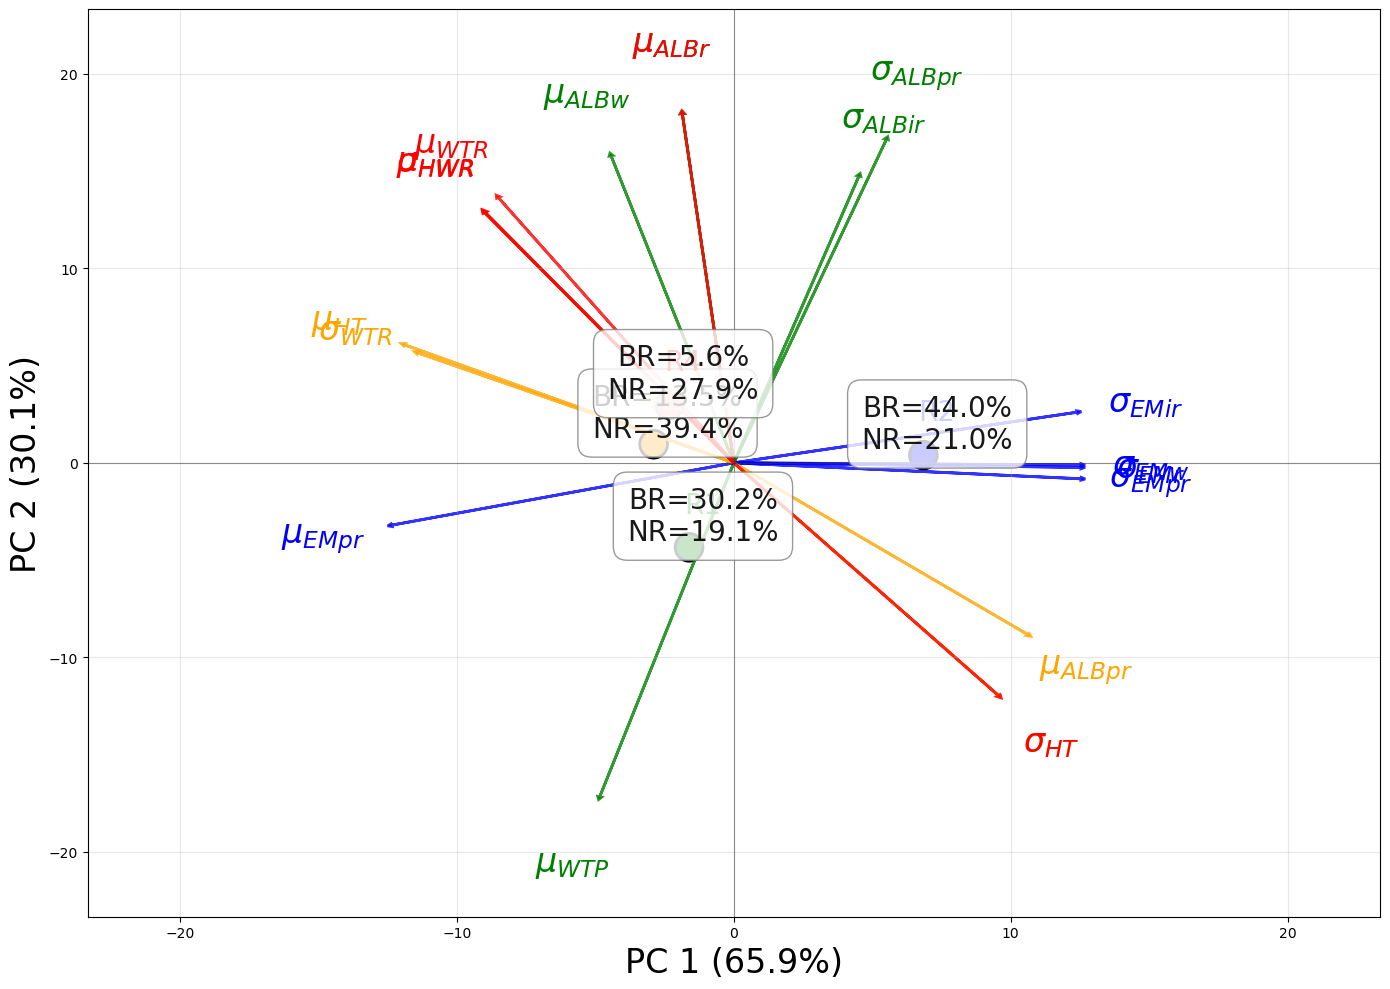

In [25]:
plot_pca_dual_text(pca_results, pca_results2, figsize=(14, 10))